In [1]:
import re
import numpy as np
import pandas as pd
file = pd.read_csv("CTR.txt", sep=";|:", header = None, engine="python")
file.drop(columns=[0], inplace = True)


In [2]:
class Strategy:
    def __init__(self, N_ads):
        self.N_ads = N_ads
        self.rewards = np.zeros(N_ads)
        self.times = np.zeros(N_ads)
        pass
    def act(self, t):
        pass
    def update(self, t, choice, reward):
        self.rewards[choice] +=reward
        self.times[choice] += 1
        pass
        

In [3]:
class Env:
    def __init__(self, file):
        self.file = file
    def act(self, choice, t):
        return file[6+ choice][t]
    def getContext(self, t, a):
        return file[t][:5]
    def evaluate(self, strategy):
        rewards, regrets = [],[]
        choices, optimalchoices = [],[]
        for i , t in enumerate(range(0, len(self.file))):
            choice = strategy.act(t)
            reward, rewardBest = self.act(choice, t), self.file.loc[t][5:].values.max()
            choices.append( choice)
            optimalchoices.append(self.file.loc[t][5:].values.argmax())
            strategy.update(t, choice, reward)
            rewards.append(reward)
            regrets.append(rewardBest - reward)
        return np.cumsum(np.array(rewards)), np.cumsum(regrets), np.array(choices), np.array(optimalchoices)
            
            
            
        
            
            

In [4]:
import random
class Random(Strategy):
    def __init__(self, N_ads):
        super().__init__(N_ads)
        pass
    def act(self, t):
        return random.randint(0, self.N_ads-1)
    

In [5]:
class StaticBest(Strategy):
    def __init__(self, N_ads,env, k=0):
        super().__init__(N_ads)
        self.k = k
        self.times +=1
    def act(self, t):
        if self.k > 0:
            self.k -=1
            return random.randint(0,self.N_ads-1)
        else:
            values= self.rewards / self.times
            return np.random.choice( np.argwhere(values == np.max(values) ).reshape( -1))
        

In [6]:
class stat(Strategy):
    def __init__(self, N_ads,file):
        super().__init__(N_ads)
        self.choice = np.argmax(file.loc[:, 6:].mean(axis=0).to_numpy())
    def act(self, t):
        return self.choice

In [7]:
class epsilon_greedy(Strategy):
    def __init__(self, N_ads,env, epsilon= 0):
        super().__init__(N_ads)
        self.epsilon = epsilon
        self.times += 1
        #self.rewards += 0.5 
    def act(self, t):
        if  np.random.rand() < self.epsilon:
            return random.randint(0,self.N_ads-1)
        else: 
            values= self.rewards / self.times
            return np.random.choice( np.argwhere(values == np.max(values) ).reshape( -1))

In [8]:
class Optimal(Strategy):
    def __init__(self, N_ads, env):
        super().__init__(N_ads)
    def act(self, t):
        return env.file.loc[t, 6:].values.argmax()

In [9]:
class UCB(Strategy):
    def __init__(self, N_ads, env, factor = np.sqrt(2)):
        super().__init__(N_ads)
        self.factor = factor
        for i in range(N_ads):
            reward = env.act(i,i)
            self.update(i,i, reward)
    def act(self, t):
        t = self.times.sum()
        return np.argmax((self.rewards/self.times) +self.factor* np.sqrt(2*np.log(t)/self.times))
        

In [17]:
class linUCB(Strategy):
    def __init__(self, N_ads, d,alpha, env, file):
        super().__init__(N_ads)
        self.env, self.alpha = env, alpha
        self.A = {}
        self.B = {}
        self.theta = np.zeros(( d, N_ads))
        self.alpha = alpha
        self.file = file
        self.nb_arms = N_ads
    def act(self,t):
        p = np.zeros(self.nb_arms)
        for a in range(self.nb_arms):
            if a not in self.A.keys():
                self.A[a] = np.identity(5)
                self.B[a] = np.zeros(5)
            inv_a = np.linalg.inv(self.A[a])
            mu_hat_a = inv_a @ self.B[a]
            
            p_a = mu_hat_a.T @ self.file.loc[t, :5].values + self.alpha \
            * np.sqrt(self.file.loc[t, :5].values @ inv_a @ self.file.loc[t, :5].values)
            p[a] = p_a
        action = np.argmax(p)
        return action
    
    def update(self,t, action, reward):
        self.rewards[action] +=reward
        self.times[action] += 1
        self.A[action] = self.A[action] + (self.file.loc[t, :5].values @ self.file.loc[t, :5].values.T)
        self.B[action] = self.B[action] + (reward* self.file.loc[t, :5].values)
        

In [18]:
env = Env(file)
r =  Random(10)
#Greedy = StaticBest(10, env, k= 1)
EG = epsilon_greedy(10, env, epsilon= 0.3)
static = stat(10, file)
optimal = Optimal(10, env)
ucb = UCB(10,env, 0.5)
linUcb = linUCB(10, 5, 2.22,env, file)

In [15]:
gainsRandom, regretsRandom, Rchoices,Roptimal = env.evaluate(r)
#gainsGreedy, regretsGreedy, choicesGreedy, optimalchoicesGreedy = env.evaluate(Greedy)

gainsOptimal, regretsOptimal, ochoice,oochoice = env.evaluate(optimal)

gainsStatic, regretsStatic, choicesStatic,optimalchoicesStatic = env.evaluate(static)


In [375]:
gainsEG, regretsEG, choicesEG, optimalchoicesEG = env.evaluate(EG)

In [388]:
gainsUcb, regretsUcb, choicesUCB, optimalchoicesUCB = env.evaluate(ucb)

In [385]:
gainslinUcb, regretslinUcb,choiceslinUCB, optimalchoiceslinUCB = env.evaluate(linUcb)

In [36]:

for delta in [0.1] :
    print(delta)
    alpha = 1 + np.sqrt(np.log(2/delta)/2)
    results[delta] = {}
    model = linUcb = linUCB(10, 5, alpha ,env, file)
    a,b,c,d = env.evaluate(model)
    
    results[delta]["gains"] = a
    results[delta]["regrets"] = b
    results[delta]["actions"] = c
    results[delta]["actions_optimale"] = d
    

0.1


In [20]:
results[delta]["gains"] = a
results[delta]["regrets"] = b
results[delta]["actions"] = c
results[delta]["actions_optimale"] = d

In [24]:
results

{2: {'gains': array([1.03419057e-01, 1.03419057e-01, 1.03419057e-01, ...,
         1.17372479e+03, 1.17372479e+03, 1.17409469e+03]),
  'regrets': array([1.31283358e-01, 4.55878923e-01, 6.49555779e-01, ...,
         3.57663730e+02, 3.57908547e+02, 3.57908547e+02]),
  'actions': array([0, 1, 2, ..., 9, 3, 3]),
  'actions_optimale': array([6, 9, 9, ..., 3, 1, 3])},
 3: {'gains': array([ 0.10341906,  0.10341906,  0.21299367, ..., 82.22438043,
         82.26612661, 82.26612661]),
  'regrets': array([1.31283358e-01, 4.55878923e-01, 5.39981165e-01, ...,
         1.44916414e+03, 1.44936721e+03, 1.44973711e+03]),
  'actions': array([0, 0, 0, ..., 0, 0, 0]),
  'actions_optimale': array([6, 9, 9, ..., 3, 1, 3])},
 4: {'gains': array([ 0.10341906,  0.10341906,  0.21299367, ..., 82.22438043,
         82.26612661, 82.26612661]),
  'regrets': array([1.31283358e-01, 4.55878923e-01, 5.39981165e-01, ...,
         1.44916414e+03, 1.44936721e+03, 1.44973711e+03]),
  'actions': array([0, 0, 0, ..., 0, 0, 0

In [200]:
for k in [1]:
    results[k] = {}
    model = epsilon_greedy(10, env, epsilon=k)
    a,b,c,d = env.evaluate(model)
    
    results[k]["gains"] = a
    results[k]["regrets"] = b
    results[k]["actions"] = c
    results[k]["actions_optimale"] = d

# Gains

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [43]:
1 + np.sqrt(np.log(2 / 0.10) / 2)

2.2238734153404085

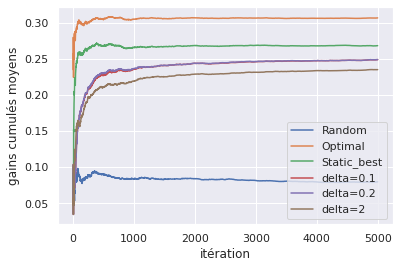

In [39]:
times = range(1, len(file)+1)
plt.plot(times,gainsRandom/ times, label= "Random")
plt.plot(times,gainsOptimal/ times, label= "Optimal")
#plt.plot(times,gainsEG/ times, label= 'epsilon_greedy')
#plt.plot(times,gainsGreedy/ times, label= 'Greedy')
plt.plot(times,gainsStatic/ times, label= 'Static_best')
#plt.plot(times,gainsUcb/ times, label= 'UCB')
for delta in [0.1,0.2,2,]:
    plt.plot(times,results[delta]["gains"]/ times, label= 'delta='+ str(delta))
plt.xlabel("itération")
plt.ylabel("gains cumulés moyens")
plt.legend(loc = "best")

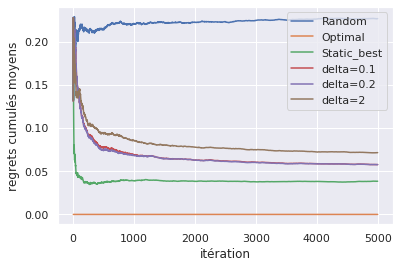

In [40]:
times = range(1, len(file)+1)
plt.plot(times,regretsRandom/ times, label= "Random")
plt.plot(times,regretsOptimal/ times, label= "Optimal")
plt.plot(times,regretsStatic/ times, label= 'Static_best')
for delta in [0.1,0.2,2,]:
    plt.plot(times,results[delta]["regrets"]/ times, label= 'delta='+ str(delta))
plt.xlabel("itération")
plt.ylabel("regrets cumulés moyens")
plt.legend(loc = "best")

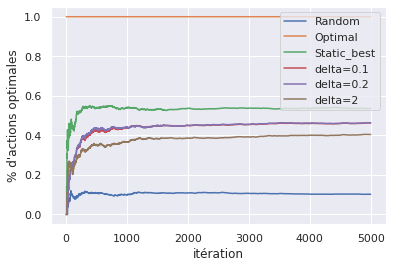

In [45]:
times = range(1, len(file)+1)
plt.plot(times,np.cumsum(Rchoices == Roptimal)/ times, label= "Random")
plt.plot(times,np.cumsum(ochoice == oochoice)/ times, label= "Optimal")
plt.plot(times,np.cumsum(choicesStatic == optimalchoicesStatic)/ times, label= 'Static_best')
for delta in [0.1,0.2,2,]:
    plt.plot(times,np.cumsum(results[delta]["actions"] == results[delta]["actions_optimale"])/ times, label= 'delta='+ str(delta))
plt.xlabel("itération")
plt.ylabel("% d'actions optimales")
plt.legend(loc = "upper right")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6e767da8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6e767e5f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6e767da890>,
 'medians': [<matplotlib.lines.Line2D at 0x7f6e7676d9d0>,
 'fliers': [],
 'means': []}

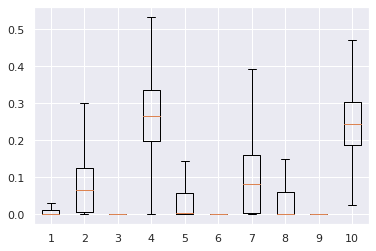

In [424]:

plt.boxplot(file.loc[:, 6:].to_numpy(),sym="")

# Regrets

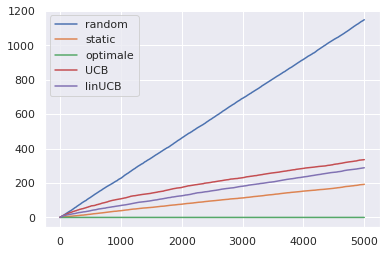

In [390]:
times = range(len(file))
plt.plot(times,regretsRandom)
plt.plot(times, regretsStatic,times ,regretsOptimal,times, regretsUcb, regretslinUcb)
plt.legend(["random", "static", "optimale", "UCB", "linUCB"])